In [39]:
# 필요한 라이브러리를 설치합니다.
# PyTorch 기반 SOTA 이미지 모델 라이브러리 ; resnet34 불러오기 위함
!pip install timm

In [40]:
import os
import time

import timm # 모델
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image # 이미지 입출력
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# EDA

In [41]:
from pathlib import Path
import pandas as pd

CANDIDATES = [Path("."), Path(".."), Path("../.."), Path("../../..")]
ROOT = None
for base in CANDIDATES:
    if (base / "train.csv").exists() and (base / "train").exists():
        ROOT = base.resolve()
        break
if ROOT is None:
    raise FileNotFoundError("train.csv 및 train 폴더를 찾지 못했습니다.")

TRAIN_DIR = ROOT / "train"
print("ROOT:", ROOT)
print("TRAIN_DIR exists:", TRAIN_DIR.exists())

train_df = pd.read_csv(ROOT / "train.csv")
train_df.head()

ROOT: /root/cv_data
TRAIN_DIR exists: True


,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16


target
0     100
1      46
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13     74
14     50
15    100
16    100
Name: count, dtype: int64

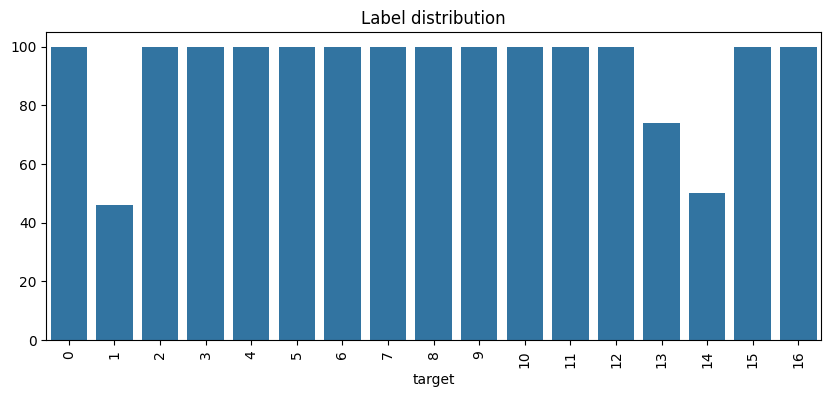

Imbalance ratio (max/min): 2.17


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = train_df["target"].value_counts().sort_index()
display(counts)

plt.figure(figsize=(10,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Label distribution")
plt.xticks(rotation=90)
plt.show()

imbalance_ratio = counts.max() / counts.min()
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

In [43]:
dup_id = train_df.duplicated(subset=["ID"]).sum()
dup_pair = train_df.duplicated(subset=["ID","target"]).sum()
id_conflict = (train_df.groupby("ID")["target"].nunique()>1).sum()

print("중복 ID:", dup_id)
print("중복 (ID,target):", dup_pair)
print("서로 다른 라벨을 가진 ID(라벨 충돌):", id_conflict)

중복 ID: 0
중복 (ID,target): 0
서로 다른 라벨을 가진 ID(라벨 충돌): 0


In [44]:
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from collections import Counter

missing, unreadable, flat_images, modes = [], [], [], []

for fname in tqdm(train_df["ID"]):
    p = TRAIN_DIR / fname
    if not p.exists():
        missing.append(fname)
        continue
    try:
        im = Image.open(p)
        modes.append(im.mode)
        arr = np.array(im)
        if arr.size == 0 or arr.std() == 0:
            flat_images.append(fname)
    except (UnidentifiedImageError, OSError):
        unreadable.append(fname)

print("없는 파일 수:", len(missing))
print("읽기 불가 파일 수:", len(unreadable))
print("단색/이상치 의심 수:", len(flat_images))
print("Image modes:", Counter(modes))

  0%|          | 0/1570 [00:00<?, ?it/s]

100%|██████████| 1570/1570 [00:06<00:00, 249.15it/s]

없는 파일 수: 0
읽기 불가 파일 수: 0
단색/이상치 의심 수: 0
Image modes: Counter({'RGB': 1570})


Checked images: 1570


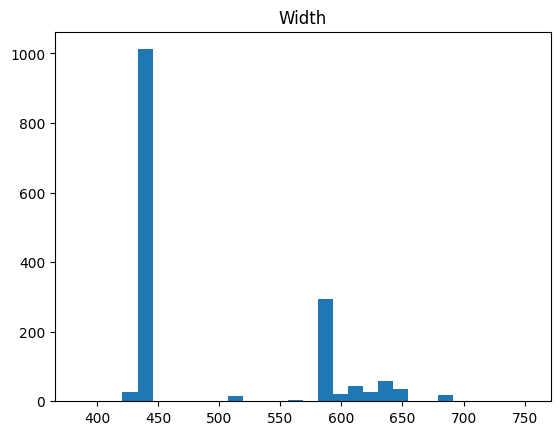

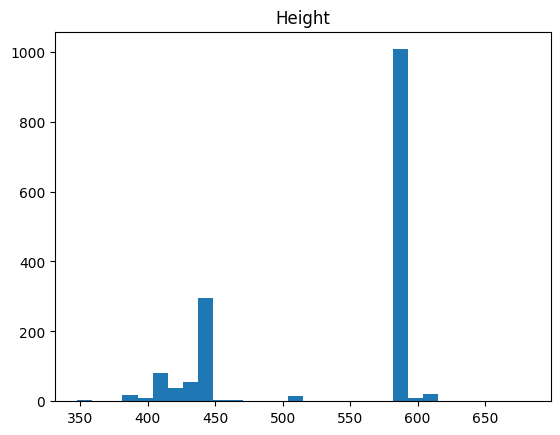

In [45]:
from PIL import Image
import matplotlib.pyplot as plt

widths, heights = [], []
checked = 0
for fname in train_df["ID"]:
    p = TRAIN_DIR / fname
    if not p.exists():
        continue
    try:
        im = Image.open(p)
        w, h = im.size
        widths.append(w); heights.append(h)
        checked += 1
    except:
        pass

print("Checked images:", checked)
plt.figure(); plt.hist(widths, bins=30); plt.title("Width"); plt.show()
plt.figure(); plt.hist(heights, bins=30); plt.title("Height"); plt.show()

# Transform(Albumentations)

In [46]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224

train_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.CLAHE(p=0.2),
    A.Normalize(),
    ToTensorV2(),
])

valid_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(),
    ToTensorV2(),
])

In [47]:
import torch, numpy as np, pandas as pd

counts = train_df["target"].value_counts().sort_index()
n_class = counts.shape[0]
class_weights = (counts.sum() / (n_class * counts)).values
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("class_weights:", class_weights)

sample_weights = train_df["target"].map(dict(counts.sum() / (n_class * counts))).values
np.save(ROOT / "class_weights.npy", class_weights.cpu().numpy())
pd.DataFrame({"ID": train_df["ID"], "target": train_df["target"], "weight": sample_weights}).to_csv(ROOT / "sample_weights.csv", index=False)
print("Saved class_weights.npy & sample_weights.csv in", ROOT)

class_weights: tensor([0.9235, 2.0077, 0.9235, 0.9235, 0.9235, 0.9235, 0.9235, 0.9235, 0.9235,
        0.9235, 0.9235, 0.9235, 0.9235, 1.2480, 1.8471, 0.9235, 0.9235])
Saved class_weights.npy & sample_weights.csv in /root/cv_data


In [48]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): # DataLoader가 배치 단위로 호출할 때 행
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name))) # PIL.Image.open()으로 읽고 numpy array로 변환 img는 (H,W,C)형태 배열
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target # (이미지 텐서, 라벨) 반환 -> DataLoader에서 (batch_size, C, H, W)형태로 묶임

In [49]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0 # 에폭 전체 손실 합계 저장
    preds_list = [] # 모델 예측값 저장
    targets_list = [] # 정답(라벨) 저장

    pbar = tqdm(loader) # 진행 상태 출력
    for image, targets in pbar: # DataLoader에서 image, targets(라벨)을 배치 단위로 불러옴
        image = image.to(device) # 이미지를 GPU로 이동
        targets = targets.to(device)

        model.zero_grad(set_to_none=True) # 이전 배치에서 계산된 gradient 초기화, 메모리 최적화

        preds = model(image) # 모델 forward pass 수행으로 예측값 출력
        loss = loss_fn(preds, targets) # 예측값과 정답을 비교해 손실 계산
        loss.backward() # 역전파 파라미터별 gradient 계산
        optimizer.step() # gradient를 이용해 모델 파라미터 업데이트

        train_loss += loss.item() # 현재 배치 손실 누적
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [50]:
@torch.no_grad()
def valid_one_epoch(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    preds_all, t_all = [], []

    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)

        logits = model(images)
        loss = loss_fn(logits, targets)
        val_loss += loss.item()

        preds = logits.argmax(1)
        preds_all.extend(preds.detach().cpu().numpy())
        t_all.extend(targets.detach().cpu().numpy())

    val_loss /= len(loader)
    val_acc = accuracy_score(t_all, preds_all)
    val_f1  = f1_score(t_all, preds_all, average="macro")
    return {"val_loss": val_loss, "val_acc": val_acc, "val_f1": val_f1}


# 하이퍼파라미터

In [51]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda 하면 GPU 사용

# data config
data_path = '/root/cv_data/' # 데이터셋 저장 경로 : 이미지 폴더와 csv 파일들 위치

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 224 # 입력 이미지 크기인데 32는 너무 작으니 224 정도로 바꾸기 
LR = 1e-3 # 학습률 AdamW은 1e-3 또는 5-4 / SGD는 1e-2 또는 1e-3 많이 사용
EPOCHS = 20 # 20~50 정도 돌려보기
BATCH_SIZE = 64 # 한번에 학습할 이미지 개수 -> GPU 메모리 용량에 따라 조정 64나 128이면 더 안정적인 gradient 추정
num_workers = 0 # DataLoader의 병렬 데이터 로딩 worker 수 0이면 메인 프로세스에서만 로딩(느려짐) 서버는 4~8 권장(코어 수 따라)

# 데이터 로드

In [52]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/root/cv_data/train.csv")

# 클래스 비율 유지하며 train/val 분리
trn_df, val_df = train_test_split(
    df,
    test_size = 0.2, # 8:2 분리
    stratify = df['target'], # 클래스 비율 유지
    random_state=42
)

# 임시 csv 저장
trn_df.to_csv('/root/cv_data/train_split.csv', index=False)
val_df.to_csv('/root/cv_data/val_split.csv', index=False)

In [54]:
# Dataset 정의
trn_dataset = ImageDataset(
    "/root/cv_data/train_split.csv",
    "/root/cv_data/train",
    transform=trn_transform
)
val_dataset = ImageDataset(
    "/root/cv_data/val_split.csv",
    "/root/cv_data/train",
    transform=tst_transform # val데이터와 tst데이터는 같은 방식으로 변환해야 하기 때문
)
tst_dataset = ImageDataset(
    "/root/cv_data/sample_submission.csv",
    "/root/cv_data/test",
    transform=tst_transform
)
print(len(trn_dataset), len(val_dataset), len(tst_dataset))

1256 314 3140


In [55]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 매 에폭마다 데이터 섞어서 배치 구성
    num_workers=num_workers,
    pin_memory=True, # gpu 전송을 빠르게 하기 위해 메모리 고정
    drop_last=False # 데이터 수가 배치 크기로 안 나눠떨어질 때 마지막 배치 버릴지 여부
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 테스트 용은 데이터 순서 유지해야 함
    num_workers=0,
    pin_memory=True
)

In [56]:
# load model
model = timm.create_model(
    model_name,        # ex) "resnet34", "efficientnet-b0"
    pretrained=True,   # ImageNet 사전학습 가중치 사용
    num_classes=17     # 대회 클래스 개수
).to(device)

# 손실 함수 (클래스 불균형 심하면 weight 옵션 추가 가능)
loss_fn = nn.CrossEntropyLoss()

# Optimizer (Adam → AdamW)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,             # 초기 learning rate (예: 1e-3)
    weight_decay=1e-4  # 정규화 효과, 과적합 방지
)

# Scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,      # 전체 epoch 수와 맞춤
    eta_min=1e-6       # 최소 learning rate (0까지 떨어지지 않도록)
)


In [57]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [58]:
best_f1 = -1.0  # 가장 높은 val macro-F1 저장용, -1.0으로 초기화(첫 에포크 성능은 무조건 갱신되도록)

for epoch in range(EPOCHS):
    # 1) Train
    tr = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)

    # 2) Validation 한 에포크 끝나고 검증
    va = valid_one_epoch(val_loader, model, loss_fn, device)

    # 3) Scheduler step (CosineAnnealingLR이면 epoch마다 호출 - 그래야 학습률 변함)
    scheduler.step()

    # 4) 로그 출력
    curr_lr = optimizer.param_groups[0]["lr"] # 현재 optimizer가 쓰는 학습률 가져옴
    print(
        f"[{epoch+1:02d}/{EPOCHS}] " # 두 자리 정수로 출력
        f"train_loss={tr['train_loss']:.4f}  train_f1={tr['train_f1']:.4f}  "
        f"val_loss={va['val_loss']:.4f}  val_f1={va['val_f1']:.4f}  lr={curr_lr:.6f}"
    )

    # 5) 베스트 모델 체크포인트 (대회 지표: macro-F1)
    if va["val_f1"] > best_f1: 
        best_f1 = va["val_f1"]
        torch.save(model.state_dict(), "best_resnet34_2.pth")
        print(f">> best updated! val_f1={best_f1:.4f}")


Loss: 1.5964: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


[01/20] train_loss=2.2520  train_f1=0.3976  val_loss=1.5493  val_f1=0.5518  lr=0.000994
>> best updated! val_f1=0.5518


Loss: 0.4736: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


[02/20] train_loss=0.8563  train_f1=0.7642  val_loss=0.5586  val_f1=0.7742  lr=0.000976
>> best updated! val_f1=0.7742


Loss: 0.2394: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


[03/20] train_loss=0.3228  train_f1=0.8777  val_loss=0.3135  val_f1=0.8787  lr=0.000946
>> best updated! val_f1=0.8787


Loss: 0.0532: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


[04/20] train_loss=0.1271  train_f1=0.9810  val_loss=0.2825  val_f1=0.8879  lr=0.000905
>> best updated! val_f1=0.8879


Loss: 0.0286: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


[05/20] train_loss=0.0470  train_f1=0.9897  val_loss=0.3275  val_f1=0.8969  lr=0.000854
>> best updated! val_f1=0.8969


Loss: 0.0746: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


[06/20] train_loss=0.0255  train_f1=0.9952  val_loss=0.2681  val_f1=0.8953  lr=0.000794


Loss: 0.0083: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


[07/20] train_loss=0.0145  train_f1=1.0000  val_loss=0.2919  val_f1=0.9004  lr=0.000727
>> best updated! val_f1=0.9004


Loss: 0.0160: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


[08/20] train_loss=0.0086  train_f1=0.9993  val_loss=0.3013  val_f1=0.9159  lr=0.000655
>> best updated! val_f1=0.9159


Loss: 0.0049: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


[09/20] train_loss=0.0059  train_f1=1.0000  val_loss=0.2995  val_f1=0.9036  lr=0.000579


Loss: 0.0271: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


[10/20] train_loss=0.0062  train_f1=0.9993  val_loss=0.2988  val_f1=0.8996  lr=0.000501


Loss: 0.0037: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


[11/20] train_loss=0.0039  train_f1=1.0000  val_loss=0.2882  val_f1=0.9018  lr=0.000422


Loss: 0.0015: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


[12/20] train_loss=0.0031  train_f1=1.0000  val_loss=0.2493  val_f1=0.9171  lr=0.000346
>> best updated! val_f1=0.9171


Loss: 0.0018: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


[13/20] train_loss=0.0021  train_f1=1.0000  val_loss=0.2569  val_f1=0.9150  lr=0.000274


Loss: 0.0024: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


[14/20] train_loss=0.0018  train_f1=1.0000  val_loss=0.2552  val_f1=0.9186  lr=0.000207
>> best updated! val_f1=0.9186


Loss: 0.0012: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


[15/20] train_loss=0.0018  train_f1=1.0000  val_loss=0.2583  val_f1=0.9186  lr=0.000147
>> best updated! val_f1=0.9186


Loss: 0.0016: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


[16/20] train_loss=0.0021  train_f1=1.0000  val_loss=0.2528  val_f1=0.9208  lr=0.000096
>> best updated! val_f1=0.9208


Loss: 0.0091: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


[17/20] train_loss=0.0022  train_f1=1.0000  val_loss=0.2629  val_f1=0.9288  lr=0.000055
>> best updated! val_f1=0.9288


Loss: 0.0012: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


[18/20] train_loss=0.0018  train_f1=1.0000  val_loss=0.2621  val_f1=0.9260  lr=0.000025


Loss: 0.0059: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


[19/20] train_loss=0.0017  train_f1=1.0000  val_loss=0.2581  val_f1=0.9222  lr=0.000007


Loss: 0.0029: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


[20/20] train_loss=0.0017  train_f1=1.0000  val_loss=0.2631  val_f1=0.9178  lr=0.000001


# 추론

In [59]:
# 1) best 모델 가중치 불러오기
model.load_state_dict(torch.load("best_resnet34_2.pth", map_location=device))
model.to(device)
model.eval()  # 평가 모드 전환

# 2) 추론 실행
preds_list = []
with torch.no_grad():  # 추론 시 gradient 계산 안 함, 한번에 감싸고 루프 전 모델 로드(가장 좋은 가중치로 추론하기 위함)
    for image, _ in tqdm(tst_loader):
        image = image.to(device)

        preds = model(image)  # (batch_size, num_classes) 출력
        preds = preds.argmax(dim=1)  # 가장 확률 높은 클래스 선택

        preds_list.extend(preds.detach().cpu().numpy())  # numpy로 변환 후 리스트에 추가


100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


In [60]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [61]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,10
4,00901f504008d884.jpg,2


In [62]:
sample_submission_df = pd.read_csv("/root/cv_data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [63]:
pred_df.to_csv("code2_pred.csv", index=False)